# **Waze Project**

## **User Churn Prediction Using Tree-Based Models**

In this section, we utilize two popular tree-based machine learning models: **Random Forest** and **XGBoost**. Both models are well-suited for classification problems like churn prediction, where understanding patterns and interactions in the data is crucial.

## **Random Forest**

Random Forest is an ensemble learning technique that builds multiple decision trees during training and outputs the majority vote for classification tasks. The ensemble approach mitigates the risk of overfitting to the training data, as it averages the results of multiple decision trees.

Advantages of Random Forest:

 * Robustness: It reduces overfitting by combining predictions from multiple trees.
 * Versatility: Handles both categorical and numerical data, and performs well with high-dimensional data.
 * Feature Importance: Provides insight into the most important features in the dataset.

Key Parameters:

 * Number of Trees (n_estimators): Defines how many decision trees are built.
 * Max Depth: Limits the depth of each tree to prevent overfitting.
 * Criterion: Determines how the quality of a split is measured (e.g., Gini Impurity or Entropy).

## **XGBoost**

XGBoost (Extreme Gradient Boosting) is a high-performance implementation of gradient boosted decision trees. It works by sequentially building trees, with each new tree aiming to correct the errors of its predecessor. XGBoost has gained popularity due to its ability to handle large datasets and its excellent performance on structured/tabular data.

Advantages of XGBoost:

* Efficiency: Fast training and prediction times due to parallelization and efficient use of memory.
* Regularization: Built-in L1 and L2 regularization to control model complexity and reduce overfitting.
* Performance: Often yields superior results compared to other algorithms, especially when tuned properly.

Key Parameters:

* Learning Rate: Controls how quickly the model adapts to the problem.
* Max Depth: The depth of individual trees, balancing complexity and overfitting.
* Objective: Defines the learning task and the corresponding loss function (e.g., Binary Logistic for binary classification).

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance
from imblearn.over_sampling import SMOTE

In [4]:
df = pd.read_csv('data/pre_process_waze.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14299 entries, 0 to 14298
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   label                            14299 non-null  object 
 1   sessions                         14299 non-null  int64  
 2   drives                           14299 non-null  int64  
 3   total_sessions                   14299 non-null  float64
 4   n_days_after_onboarding          14299 non-null  int64  
 5   total_navigations_fav1           14299 non-null  int64  
 6   total_navigations_fav2           14299 non-null  int64  
 7   driven_km_drives                 14299 non-null  float64
 8   duration_minutes_drives          14299 non-null  float64
 9   activity_days                    14299 non-null  int64  
 10  driving_days                     14299 non-null  int64  
 11  device                           14299 non-null  object 
 12  km_per_drive      

In [6]:
df.shape

(14299, 22)

In [7]:
df.head(4)

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,...,km_per_drive,km_per_driving_day,drives_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,percent_of_sessions_to_favorite,device2,label2
0,retained,243,200,296.748273,2276,208,0,2628.845068,1985.775061,28,...,11.632058,138.360267,11.894737,0.953670,1,0.130381,79.430298,0.700931,0,0
1,retained,133,107,326.896596,1225,19,64,8898.716275,3160.472914,13,...,128.186173,1246.901868,9.727273,0.406856,0,0.266854,260.389902,0.253903,1,0
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,...,32.201567,382.393602,11.875000,0.841186,0,0.051121,113.953460,0.000000,0,0
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,...,22.839778,304.530374,13.333333,0.724968,0,1.089743,93.351141,4.867640,1,0


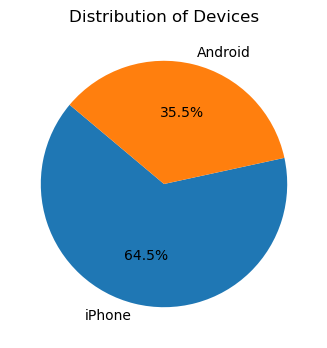

In [8]:
feature = 'device'
plt.figure(figsize=(8, 4))           
plt.pie(df[feature].value_counts(), labels=df[feature].value_counts().index, autopct='%1.1f%%', startangle=140)    
plt.title(f'Distribution of Devices')
plt.show()

In [9]:
# 1. Isolate X variables
X = df.drop(columns=['label', 'label2', 'device'])

# 2. Isolate y variable
y = df['label2']

## Balancing Data 

In [10]:
# Apply SMOTE before splitting the data
smote = SMOTE(sampling_strategy=0.8, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

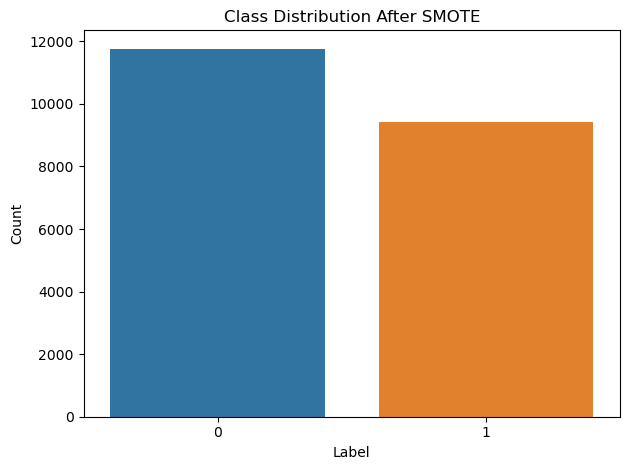

In [11]:
# Define custom colors for the labels
colors = ['#1f77b4', '#ff7f0e']  # Example: blue for 0, orange for 1

# Plot the class distribution after SMOTE
plt.plot()
sns.countplot(x=pd.Series(y_res), palette=colors)
plt.title("Class Distribution After SMOTE")
plt.xlabel('Label')
plt.ylabel('Count')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

### **Modeling workflow and model selection process**

The final modeling dataset contains 14,299 samples. This is towards the lower end of what might be considered sufficient to conduct a robust model selection process, but still doable.

1. Split the data into train/validation/test sets (60/20/20)

Note that, when deciding the split ratio and whether or not to use a validation set to select a champion model, consider both how many samples will be in each data partition, and how many examples of the minority class each would therefore contain. In this case, a 60/20/20 split would result in \~2,860 samples in the validation set and the same number in the test set, of which \~18%&mdash;or 515 samples&mdash;would represent users who churn.
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

![](https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg)

### **Split the data**

Now you're ready to model. The only remaining step is to split the data into features/target variable and training/validation/test sets.

1. Define a variable `X` that isolates the features. Remember not to use `device`.

2. Define a variable `y` that isolates the target variable (`label2`).

3. Split the data 80/20 into an interim training set and a test set. Don't forget to stratify the splits, and set the random state to 42.

4. Split the interim training set 75/25 into a training set and a validation set, yielding a final ratio of 60/20/20 for training/validation/test sets. Again, don't forget to stratify the splits and set the random state.

In [12]:
# 3. Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X_res, y_res, stratify=y_res,
                                              test_size=0.2, random_state=42)

# 4. Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,
                                                  test_size=0.25, random_state=42)

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12703 entries, 5739 to 11527
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   sessions                         12703 non-null  int64  
 1   drives                           12703 non-null  int64  
 2   total_sessions                   12703 non-null  float64
 3   n_days_after_onboarding          12703 non-null  int64  
 4   total_navigations_fav1           12703 non-null  int64  
 5   total_navigations_fav2           12703 non-null  int64  
 6   driven_km_drives                 12703 non-null  float64
 7   duration_minutes_drives          12703 non-null  float64
 8   activity_days                    12703 non-null  int64  
 9   driving_days                     12703 non-null  int64  
 10  km_per_drive                     12703 non-null  float64
 11  km_per_driving_day               12703 non-null  float64
 12  drives_per_driv

#### **Random forest**

Begin with using `GridSearchCV` to tune a random forest model.

1. Instantiate the random forest classifier `rf` and set the random state.

2. Create a dictionary `cv_params` of any of the following hyperparameters and their corresponding values to tune. The more you tune, the better your model will fit the data, but the longer it will take.
 - `max_depth`
 - `max_features`
 - `max_samples`
 - `min_samples_leaf`
 - `min_samples_split`
 - `n_estimators`

3. Define a dictionary `scoring` of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `rf_cv`. Pass to it as arguments:
 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit=_`)

 `refit` should be set to `'recall'`.<font/>

In [14]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

Now fit the model to the training data.

In [15]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: total: 12min 1s
Wall time: 14min 22s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [16]:
# Examine best score
rf_cv.best_score_

0.7587671131116701

In [17]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [18]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [19]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.762215,0.758767,0.760462,0.787531


After training the Random Forest model, we evaluated its performance using cross-validation to ensure robust and generalizable results. Cross-validation helps to mitigate overfitting by splitting the dataset into multiple folds and averaging the model's performance across these folds.

* Precision: The Random Forest model correctly predicted churned users 76.2% of the time out of all users predicted to churn.
* Recall: The model identified 75.9% of all actual churned users.
* F1-Score: The harmonic mean of precision and recall, indicating a good balance between the two.
* Accuracy: The overall performance of the model, correctly predicting 78.75% of the cases.

These results suggest that the Random Forest model performs well in distinguishing between churned and non-churned users.

## **XGBoost**

 Try to improve your scores using an XGBoost model.

1. Instantiate the XGBoost classifier `xgb` and set `objective='binary:logistic'`. Also set the random state.

2. Create a dictionary `cv_params` of the following hyperparameters and their corresponding values to tune:
 - `max_depth`
 - `min_child_weight`
 - `learning_rate`
 - `n_estimators`

3. Define a dictionary `scoring` of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `xgb_cv`. Pass to it as arguments:
 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit='recall'`)

In [20]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

Now fit the model to the `X_train` and `y_train` data.

Note this cell might take several minutes to run.

In [21]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 20min 6s
Wall time: 8min 53s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [22]:
# Examine best score
xgb_cv.best_score_

0.7879905306946835

In [23]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 300}

In [24]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.762215,0.758767,0.760462,0.787531
0,XGB cv,0.789754,0.787991,0.788821,0.812485


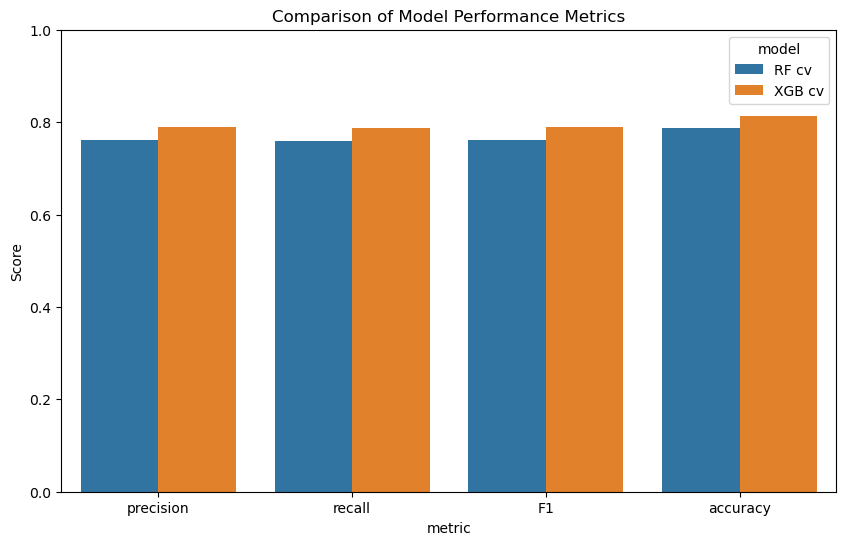

In [25]:
# Melt the dataframe for easier plotting
results_melted = results.melt(id_vars="model", var_name="metric", value_name="value")

# Set the plot size
plt.figure(figsize=(10, 6))

# Bar plot with hue as 'model'
sns.barplot(x='metric', y='value', hue='model', data=results_melted)

# Add titles and labels
plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Ensure consistent scale for metrics
plt.show()

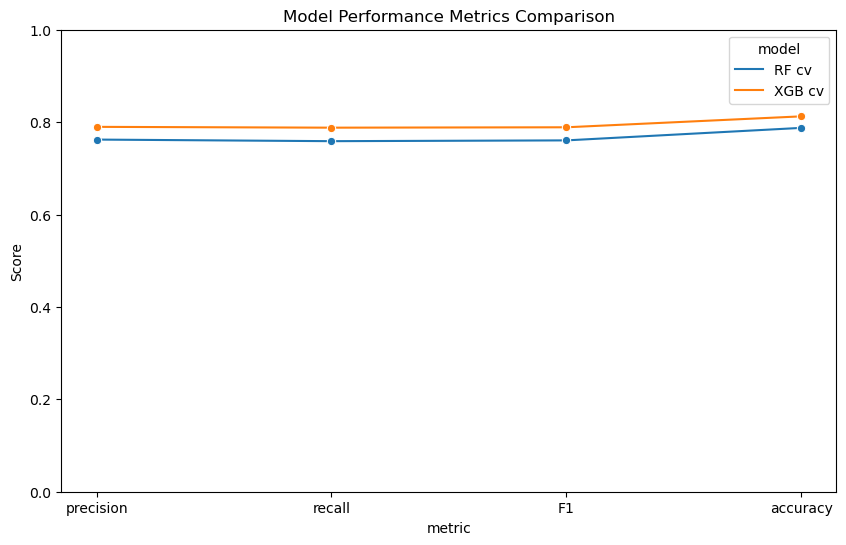

In [26]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Line plot to compare metrics for both models
sns.lineplot(x='metric', y='value', hue='model', marker='o', data=results_melted)

# Add titles and labels
plt.title('Model Performance Metrics Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

XGB (cv) outperforms RF (cv) across all metrics, showing better precision, recall, F1 score, and accuracy.
The differences in precision and recall are relatively small, but XGB consistently edges out RF, leading to a higher F1 score and accuracy.

### **Model selection**

Now, use the best random forest model and the best XGBoost model to predict on the validation data. Whichever performs better will be selected as the champion model.

#### **Random forest**

In [27]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

Use the `get_test_scores()` function to generate a table of scores from the predictions on the validation data.

In [28]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [29]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.762215,0.758767,0.760462,0.787531
0,XGB cv,0.789754,0.787991,0.788821,0.812485
0,RF val,0.789859,0.744952,0.766749,0.798583


#### **XGBoost**

Now, do the same thing to get the performance scores of the XGBoost model on the validation data.

In [30]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.762215,0.758767,0.760462,0.787531
0,XGB cv,0.789754,0.787991,0.788821,0.812485
0,RF val,0.789859,0.744952,0.766749,0.798583
0,XGB val,0.816986,0.792242,0.804424,0.828808


### **Use champion model to predict on test data**

Now, use the champion model to predict on the test dataset. This is to give a final indication of how you should expect the model to perform on new future data, should you decide to use the model.

In [31]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.762215,0.758767,0.760462,0.787531
0,XGB cv,0.789754,0.787991,0.788821,0.812485
0,RF val,0.789859,0.744952,0.766749,0.798583
0,XGB val,0.816986,0.792242,0.804424,0.828808
0,XGB test,0.803879,0.792774,0.798288,0.821960


The recall was exactly the same as it was on the validation data, but the precision declined notably, which caused all of the other scores to drop slightly. Nonetheless, this is stil within the acceptable range for performance discrepancy between validation and test scores.

## **Confusion matrix**

Plot a confusion matrix of the champion model's predictions on the test data.

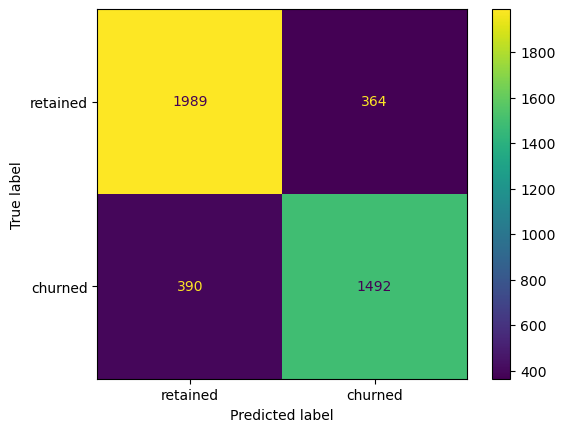

In [32]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

### **Feature importance**

Use the `plot_importance` function to inspect the most important features of your final model.

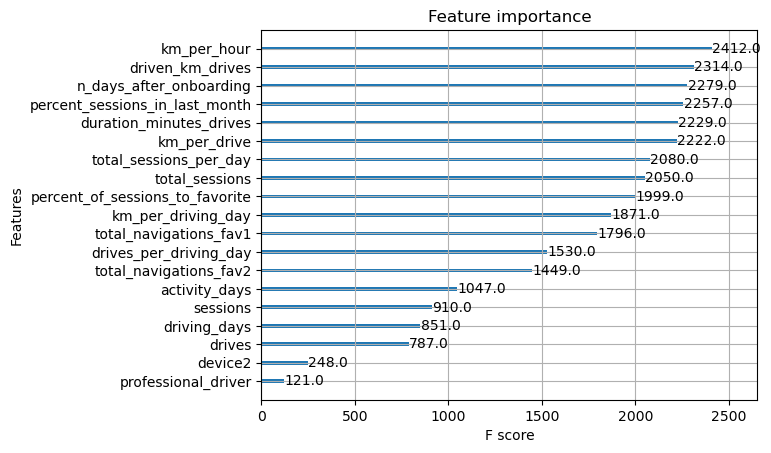

In [33]:
plot_importance(xgb_cv.best_estimator_);

The XGBoost model made more use of many of the features than did the logistic regression model from the previous course, which weighted a single feature (`activity_days`) very heavily in its final prediction.

If anything, this underscores the importance of feature engineering. Notice that engineered features accounted for six of the top 10 features (and three of the top five). Feature engineering is often one of the best and easiest ways to boost model performance.

Also, note that the important features in one model might not be the same as the important features in another model. That's why you shouldn't discount features as unimportant without thoroughly examining them and understanding their relationship with the dependent variable, if possible. These discrepancies between features selected by models are typically caused by complex feature interactions.

Remember, sometimes your data simply will not be predictive of your chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If your data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion.

Even if you cannot use the model to make strong predictions, was the work done in vain? What insights can you report back to stakeholders?

### **Conclusion**

Now that you've built and tested your machine learning models, the next step is to share your findings with the Waze leadership team. Consider the following questions as you prepare to write your executive summary. Think about key points you may want to share with the team, and what information is most relevant to the user churn project.

**Questions:**

1. Would you recommend using this model for churn prediction? Why or why not?

> _It depends. What would the model be used for? If it's used to drive consequential business decisions, then no. The model is not a strong enough predictor, as made clear by its poor recall score. However, if the model is only being used to guide further exploratory efforts, then it can have value._

2. What tradeoff was made by splitting the data into training, validation, and test sets as opposed to just training and test sets?

> _Splitting the data three ways means that there is less data available to train the model than splitting just two ways. However, performing model selection on a separate validation set enables testing of the champion model by itself on the test set, which gives a better estimate of future performance than splitting the data two ways and selecting a champion model by performance on the test data._

3. What is the benefit of using a logistic regression model over an ensemble of tree-based models (like random forest or XGBoost) for classification tasks?

> _Logistic regression models are easier to interpret. Because they assign coefficients to predictor variables, they reveal not only which features factored most heavily into their final predictions, but also the directionality of the weight. In other words, they tell you if each feature is positively or negatively correlated with the target in the model's final prediction._

4. What is the benefit of using an ensemble of tree-based models like random forest or XGBoost over a logistic regression model for classification tasks?

> _Tree-based model ensembles are often better predictors. If the most important thing is the predictive power of the model, then tree-based modeling will usually win out against logistic regression (but not always!). They also require much less data cleaning and require fewer assumptions about the underlying distributions of their predictor variables, so they're easier to work with._

5. What could you do to improve this model?

> _New features could be engineered to try to generate better predictive signal, as they often do if you have domain knowledge. In the case of this model, the engineered features made up over half of the top 10 most-predictive features used by the model. It could also be helpful to reconstruct the model with different combinations of predictor variables to reduce noise from unpredictive features._

6. What additional features would you like to have to help improve the model?

> _It would be helpful to have drive-level information for each user (such as drive times, geographic locations, etc.). It would probably also be helpful to have more granular data to know how users interact with the app. For example, how often do they report or confirm road hazard alerts? Finally, it could be helpful to know the monthly count of unique starting and ending locations each driver inputs._


### **BONUS**

The following content is not required, but demonstrates further steps that you might take to tailor your model to your use case.

#### **Identify an optimal decision threshold**

The default decision threshold for most implementations of classification algorithms&mdash;including scikit-learn's&mdash;is 0.5. This means that, in the case of the Waze models, if they predicted that a given user had a 50% probability or greater of churning, then that user was assigned a predicted value of `1`&mdash;the user was predicted to churn.

With imbalanced datasets where the response class is a minority, this threshold might not be ideal. You learned that a precision-recall curve can help to visualize the trade-off between your model's precision and recall.

Here's the precision-recall curve for the XGBoost champion model on the test data.

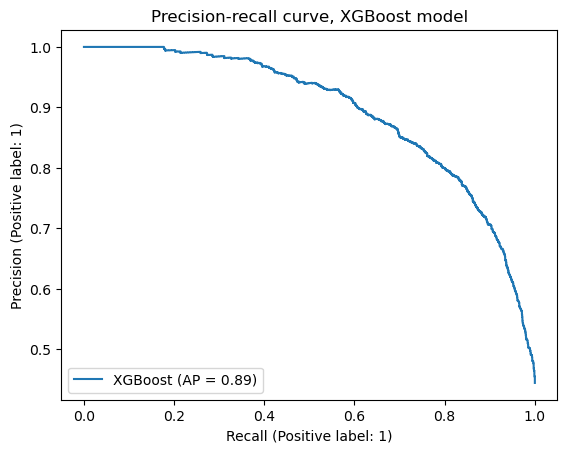

In [34]:
# Plot precision-recall curve
display = PrecisionRecallDisplay.from_estimator(
    xgb_cv.best_estimator_, X_test, y_test, name='XGBoost'
    )
plt.title('Precision-recall curve, XGBoost model');

As recall increases, precision decreases. But what if you determined that false positives aren't much of a problem? For example, in the case of this Waze project, a false positive could just mean that a user who will not actually churn gets an email and a banner notification on their phone. It's very low risk.

So, what if instead of using the default 0.5 decision threshold of the model, you used a lower threshold?

Here's an example where the threshold is set to 0.4:

In [35]:
# Get predicted probabilities on the test data
predicted_probabilities = xgb_cv.best_estimator_.predict_proba(X_test)
predicted_probabilities

array([[0.31687164, 0.68312836],
       [0.8456736 , 0.15432636],
       [0.10152733, 0.89847267],
       ...,
       [0.7136736 , 0.28632638],
       [0.9888811 , 0.01111887],
       [0.00140876, 0.99859124]], dtype=float32)

The `predict_proba()` method returns a 2-D array of probabilities where each row represents a user. The first number in the row is the probability of belonging to the negative class, the second number in the row is the probability of belonging to the positive class. (Notice that the two numbers in each row are complimentary to each other and sum to one.)

You can generate new predictions based on this array of probabilities by changing the decision threshold for what is considered a positive response. For example, the following code converts the predicted probabilities to {0, 1} predictions with a threshold of 0.4. In other words, any users who have a value ≥ 0.4 in the second column will get assigned a prediction of `1`, indicating that they churned.

In [36]:
# Create a list of just the second column values (probability of target)
probs = [x[1] for x in predicted_probabilities]

# Create an array of new predictions that assigns a 1 to any value >= 0.4
new_preds = np.array([1 if x >= 0.4 else 0 for x in probs])
new_preds

array([1, 0, 1, ..., 0, 0, 1])

In [37]:
# Get evaluation metrics for when the threshold is 0.4
get_test_scores('XGB, threshold = 0.4', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.4",0.776737,0.837407,0.805932,0.820779


In [38]:
results

,model,precision,recall,F1,accuracy
0,RF cv,0.762215,0.758767,0.760462,0.787531
0,XGB cv,0.789754,0.787991,0.788821,0.812485
0,RF val,0.789859,0.744952,0.766749,0.798583
0,XGB val,0.816986,0.792242,0.804424,0.828808
0,XGB test,0.803879,0.792774,0.798288,0.821960


Recall and F1 score increased significantly, while precision and accuracy decreased.

So, using the precision-recall curve as a guide, suppose you knew that you'd be satisfied if the model had a recall score of 0.5 and you were willing to accept the \~30% precision score that comes with it. In other words, you'd be happy if the model successfully identified half of the people who will actually churn, even if it means that when the model says someone will churn, it's only correct about 30% of the time.

What threshold will yield this result? There are a number of ways to determine this. Here's one way that uses a function to accomplish this.

In [39]:
def threshold_finder(y_test_data, probabilities, desired_recall):
    '''
    Find the decision threshold that most closely yields a desired recall score.

    Inputs:
        y_test_data: Array of true y values
        probabilities: The results of the `predict_proba()` model method
        desired_recall: The recall that you want the model to have

    Outputs:
        threshold: The decision threshold that most closely yields the desired recall
        recall: The exact recall score associated with `threshold`
    '''
    probs = [x[1] for x in probabilities]  # Isolate second column of `probabilities`
    thresholds = np.arange(0, 1, 0.001)    # Set a grid of 1,000 thresholds to test

    scores = []
    for threshold in thresholds:
        # Create a new array of {0, 1} predictions based on new threshold
        preds = np.array([1 if x >= threshold else 0 for x in probs])
        # Calculate recall score for that threshold
        recall = recall_score(y_test_data, preds)
        # Append the threshold and its corresponding recall score as a tuple to `scores`
        scores.append((threshold, recall))

    distances = []
    for idx, score in enumerate(scores):
        # Calculate how close each actual score is to the desired score
        distance = abs(score[1] - desired_recall)
        # Append the (index#, distance) tuple to `distances`
        distances.append((idx, distance))

    # Sort `distances` by the second value in each of its tuples (least to greatest)
    sorted_distances = sorted(distances, key=lambda x: x[1], reverse=False)
    # Identify the tuple with the actual recall closest to desired recall
    best = sorted_distances[0]
    # Isolate the index of the threshold with the closest recall score
    best_idx = best[0]
    # Retrieve the threshold and actual recall score closest to desired recall
    threshold, recall = scores[best_idx]

    return threshold, recall


In [40]:
# Get the predicted probabilities from the champion model
probabilities = xgb_cv.best_estimator_.predict_proba(X_test)

# Call the function
threshold_finder(y_test, probabilities, 0.5)

(0.892, 0.5)

Setting a threshold of 0.124 will result in a recall of 0.503.

To verify, you can repeat the steps performed earlier to get the other evaluation metrics for when the model has a threshold of 0.124. Based on the precision-recall curve, a 0.5 recall score should have a precision of \~0.3.

In [41]:
# Create an array of new predictions that assigns a 1 to any value >= 0.124
new_preds = np.array([1 if x >= 0.124 else 0 for x in probs])

# Get evaluation metrics for when the threshold is 0.124
get_test_scores('XGB, threshold = 0.124', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.124",0.65462,0.933581,0.769601,0.751594


It worked! Hopefully now you understand that changing the decision threshold is another tool that can help you achieve useful results from your model.